<a href="https://colab.research.google.com/github/AbdalrahmanAliElnashar/CNN-Projects/blob/main/01-Digit_Recognizer/Digit_Recognizer_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This Notebook is concerned with **Digit Recognizing** from MNIST Dataset Using **CNN**


-----



### 1.1 Upload Kaggle.json to connect Colab to kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abdalrahmanelnashar","key":"f2bec9720ff7fca08e17f5c9f67dc36f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## 1.2 Download dataset form Kaggle

In [ ]:
! kaggle competitions download -c digit-recognizer

 78% 12.0M/15.3M [00:00<00:00, 21.9MB/s]
100% 15.3M/15.3M [00:00<00:00, 16.9MB/s]


## 1.3 Unzip dataset

In [ ]:
!unzip /content/digit-recognizer.zip

Archive:  /content/digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## 1.4 Import libraries

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

# 2. Data Preparation

## 2.1 Laod Dataset

In [ ]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [ ]:
X_train = train_data.drop(labels='label', axis= 1)
Y_train = train_data['label'] # Y_train = train.label

In [ ]:
print(train_data.shape)
print(X_train.shape)
print(Y_train.shape)

(42000, 785)
(42000, 784)
(42000,)


In [ ]:
# Check balance in training dataset
print(Y_train.value_counts(ascending=False))

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64


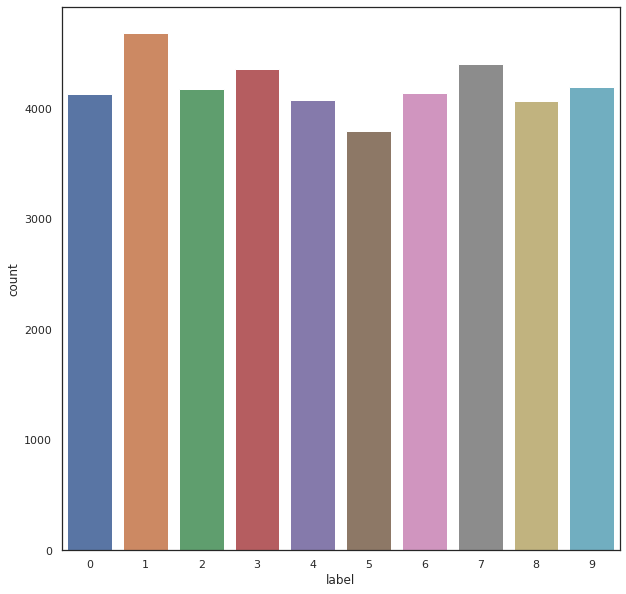

In [ ]:
plt.figure(figsize=(10, 10))
sns.countplot(x=Y_train)
plt.show()

## 2.2 Check missing values

In [ ]:
missing = X_train.isnull().any()
if missing.any() == True:
    print("There are missing values in the training data")
else:
    print('There are not missing values in the training data')

There are not missing values in the training data


In [ ]:
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


## 2.3 Normalization

In [ ]:
X_train = X_train / 255.0
X_test = test_data / 255.0 # Dataframe Object
X_train = np.array(X_train) # Covert to numpy array
X_test = np.array(X_test) # Covert to numpy array

In [ ]:
print(type(X_train))

<class 'numpy.ndarray'>


## 2.4 Reshape

In [ ]:
X_train = X_train.reshape(-1, 28,28, 1) # you can replace len(X_train) with -1
X_test = X_test.reshape(-1, 28,28, 1)   #  you can replace len(X_test) with -1  
print(X_train.shape)
print(X_test.shape)

(42000, 28, 28, 1)
(28000, 28, 28, 1)


## 2.5 label Encoding

In [ ]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

## 2.6 Split training and valdiation set


In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=2)

## 2.7 Figure some images

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


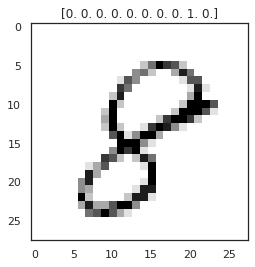

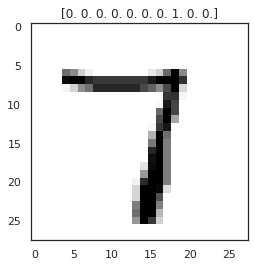

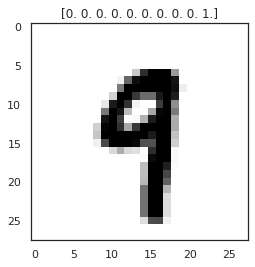

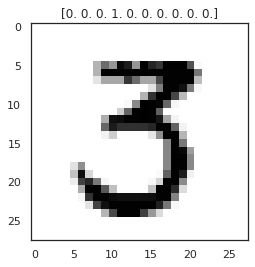

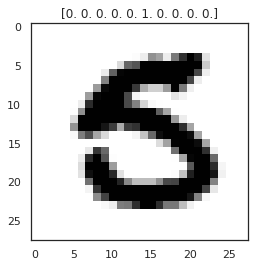

In [ ]:
for i in range(5):
    plt.imshow(X_train[i][:,:,0], cmap=plt.cm.binary)
    plt.title(Y_train[i])
    plt.show()

# Build CNN

## 3.1 Initialize the CNN Network

In [ ]:
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(28,28,1), padding='same'))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

          
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
          
model.add(Flatten())
model.add(Dense(265, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))   

### 3.1.2 Optimizer

In [ ]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

### 3.1.2 Compile Neural Network

In [ ]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

### 3.1.3 Learning rate Reduction

In [ ]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

### 3.1.4 Epochs and batch size

In [ ]:
epochs = 10
batch_size = 86

## 3.2 Train model without Data Augmentation

In [ ]:
# Without data augmentation i obtained an accuracy of 0.98114
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
         validation_data = (X_val, Y_val), verbose = 2)

Epoch 1/10
440/440 - 13s - loss: 0.2377 - accuracy: 0.9251 - val_loss: 0.0699 - val_accuracy: 0.9779 - 13s/epoch - 29ms/step
Epoch 2/10
440/440 - 3s - loss: 0.0737 - accuracy: 0.9780 - val_loss: 0.0373 - val_accuracy: 0.9893 - 3s/epoch - 8ms/step
Epoch 3/10
440/440 - 3s - loss: 0.0555 - accuracy: 0.9837 - val_loss: 0.0348 - val_accuracy: 0.9895 - 3s/epoch - 8ms/step
Epoch 4/10
440/440 - 3s - loss: 0.0473 - accuracy: 0.9863 - val_loss: 0.0342 - val_accuracy: 0.9912 - 3s/epoch - 8ms/step
Epoch 5/10
440/440 - 3s - loss: 0.0381 - accuracy: 0.9885 - val_loss: 0.0296 - val_accuracy: 0.9910 - 3s/epoch - 8ms/step
Epoch 6/10
440/440 - 3s - loss: 0.0350 - accuracy: 0.9901 - val_loss: 0.0255 - val_accuracy: 0.9924 - 3s/epoch - 8ms/step
Epoch 7/10
440/440 - 3s - loss: 0.0330 - accuracy: 0.9902 - val_loss: 0.0276 - val_accuracy: 0.9917 - 3s/epoch - 8ms/step
Epoch 8/10
440/440 - 3s - loss: 0.0304 - accuracy: 0.9910 - val_loss: 0.0285 - val_accuracy: 0.9917 - 3s/epoch - 8ms/step
Epoch 9/10
440/440 - 

###  3.2.1 Save the model

In [ ]:
# Save Model
model.save(r'content/Saved_Model_1.h5')

## 3.3 Data Augmentation using **ImageDataGenerator**

In [ ]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

### 3.3.1 train model with data augmentaion

In [ ]:
# Fit the model
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/10


439/439 - 12s - loss: 0.0778 - accuracy: 0.9773 - val_loss: 0.0278 - val_accuracy: 0.9898 - lr: 0.0010 - 12s/epoch - 27ms/step
Epoch 2/10


439/439 - 12s - loss: 0.0703 - accuracy: 0.9802 - val_loss: 0.0340 - val_accuracy: 0.9902 - lr: 0.0010 - 12s/epoch - 27ms/step
Epoch 3/10


439/439 - 12s - loss: 0.0716 - accuracy: 0.9801 - val_loss: 0.0235 - val_accuracy: 0.9929 - lr: 0.0010 - 12s/epoch - 28ms/step
Epoch 4/10


439/439 - 13s - loss: 0.0640 - accuracy: 0.9813 - val_loss: 0.0316 - val_accuracy: 0.9929 - lr: 0.0010 - 13s/epoch - 29ms/step
Epoch 5/10


439/439 - 12s - loss: 0.0665 - accuracy: 0.9818 - val_loss: 0.0270 - val_accuracy: 0.9917 - lr: 0.0010 - 12s/epoch - 27ms/step
Epoch 6/10


439/439 - 12s - loss: 0.0680 - accuracy: 0.9809 - val_loss: 0.0367 - val_accuracy: 0.9898 - lr: 0.0010 - 12s/epoch - 28ms/step
Epoch 7/10


439/439 - 12s - loss: 0.0702 - accuracy: 0.9810 - val_loss: 0.0226 - val_accuracy: 0.9924 - lr: 0.0010 - 12s/epoch - 27ms/step
Epoch 8/10


439/439 - 12s - loss: 0.0614 - accuracy: 0.9830 - val_loss: 0.0228 - val_accuracy: 0.9929 - lr: 0.0010 - 12s/epoch - 27ms/step
Epoch 9/10


439/439 - 12s - loss: 0.0709 - accuracy: 0.9818 - val_loss: 0.0247 - val_accuracy: 0.9924 - lr: 0.0010 - 12s/epoch - 27ms/step
Epoch 10/10


439/439 - 12s - loss: 0.0673 - accuracy: 0.9825 - val_loss: 0.0323 - val_accuracy: 0.9929 - lr: 0.0010 - 12s/epoch - 28ms/step


### 3.3.2 Save the model

In [ ]:
model.save(r'content/Saved_Model_2.h5')

## 3.4 Model Evaluation

### 3.4.1 Accuarcy and Loss Function

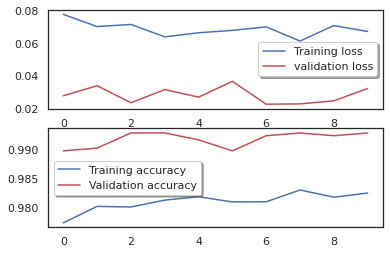

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### 3.4.2 Confusion Matrix

132/132 [==============================] - 0s 2ms/step


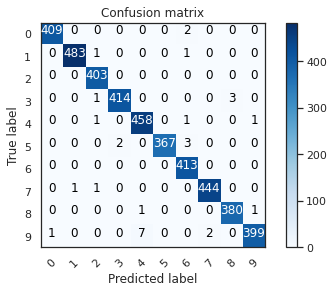

In [ ]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## 3.5 Plot some error results 


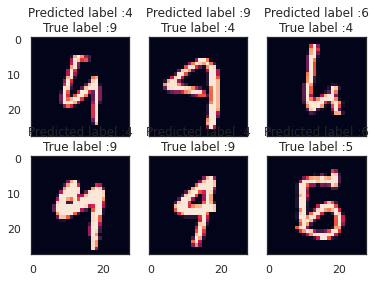

In [ ]:

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## 3.6 Predict the Digit

In [ ]:
# predict results
results = model.predict(X_test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")


875/875 [==============================] - 3s 3ms/step


In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)